In [1]:
import cheetah
import pandas as pd
import torch

In [2]:
df = pd.read_csv("../electron_tt43.out", delim_whitespace=True, skiprows=45)

# Shift column names to the left
df.columns = df.columns[1:].tolist() + [""]
# Remove first row
df = df.iloc[1:]
# Drop last column
df = df.iloc[:, :-1]
# Convert all columns except for NAME and KEYWORD to float
df[df.columns[2:]] = df[df.columns[2:]].astype(float)

df


,NAME,KEYWORD,S,L,SIGMA_X,SIGMA_Y,BETX,BETY,DX,DPX,...,DPY,ALFX,ALFY,X,Y,K1L,MUX,MUY,ENV_X,ENV_Y
1,TT43$START,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,BEGI.1000,MARKER,0.000000,0.000000,0.000982,0.000982,5.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,DRIFT_0,DRIFT,0.179170,0.179170,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
4,BPM.430028,MONITOR,0.179170,0.000000,0.000983,0.000983,5.006420,5.006420,0.000000,0.000000,...,0.000000,-0.035834,-0.035834,0.0,0.0,0.0,0.005701,0.005701,0.0,0.0
5,DRIFT_1,DRIFT,0.248570,0.069400,0.000984,0.000984,5.012357,5.012357,0.000000,0.000000,...,0.000000,-0.049714,-0.049714,0.0,0.0,0.0,0.007906,0.007906,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,IRIS2,INSTRUMENT,25.692571,0.000000,0.009802,0.010878,497.773560,494.605213,-0.005214,-0.000397,...,-0.056194,-44.983456,-43.909992,0.0,0.0,0.0,1.133650,2.080197,0.0,0.0
100,DRIFT_40,DRIFT,26.192571,0.500000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
101,PLASMA.S,INSTRUMENT,26.192571,0.000000,0.010245,0.011367,543.773800,539.490269,-0.005413,-0.000397,...,-0.056194,-47.017023,-45.860121,0.0,0.0,0.0,1.133803,2.080351,0.0,0.0
102,DRIFT_41,DRIFT,30.000000,3.807429,0.013617,0.015086,960.761021,945.248720,-0.006923,-0.000397,...,-0.056194,-62.502344,-60.710072,0.0,0.0,0.0,1.134642,2.081200,0.0,0.0


In [3]:
df.columns

Index(['NAME', 'KEYWORD', 'S', 'L', 'SIGMA_X', 'SIGMA_Y', 'BETX', 'BETY', 'DX',
       'DPX', 'DY', 'DPY', 'ALFX', 'ALFY', 'X', 'Y', 'K1L', 'MUX', 'MUY',
       'ENV_X', 'ENV_Y'],
      dtype='object')

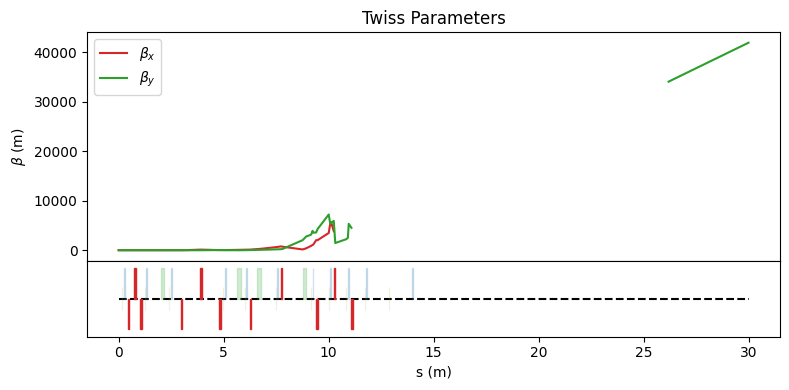

In [4]:
def convert_row_to_element(row) -> cheetah.Element:
    """Takes a row from the MADX output file and converts it into a Cheetah element."""
    sanitized_name = row.NAME.replace(".", "_")

    if row.KEYWORD == "MARKER":
        assert row.L == 0.0
        return cheetah.Marker(name=sanitized_name)
    elif row.KEYWORD == "DRIFT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "MONITOR":
        assert row.L == 0.0
        assert sanitized_name.startswith("BPM")
        return cheetah.BPM(name=sanitized_name)
    elif row.KEYWORD == "KICKER":
        # TODO: Horizontal or vertical?
        return cheetah.HorizontalCorrector(
            name=sanitized_name, length=torch.as_tensor(row.L)
        )
    elif row.KEYWORD == "QUADRUPOLE":
        return cheetah.Quadrupole(
            name=sanitized_name,
            length=torch.as_tensor(row.L),
            k1=torch.as_tensor(row.K1L / row.L),  # TODO: Correct?
        )
    elif row.KEYWORD == "INSTRUMENT":
        return cheetah.Drift(name=sanitized_name, length=torch.as_tensor(row.L))
    elif row.KEYWORD == "RBEND":
        return cheetah.RBend(name=sanitized_name, length=torch.as_tensor(row.L))
    else:
        raise NotImplementedError(f"Unknown element type: {row.KEYWORD}")


segment = cheetah.Segment(
    elements=[convert_row_to_element(row) for row in df.itertuples()]
)

incoming_beam = cheetah.ParameterBeam.from_twiss(
    energy=torch.as_tensor(0.019006870) * 1e12,  # TODO: TeV -> eV ?
    beta_x=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETX"].values[0]),
    beta_y=torch.as_tensor(df.loc[df.NAME == "TT43$START", "BETY"].values[0]),
    emittance_x=torch.as_tensor(0.000000269),  # TODO: Unit?
    emittance_y=torch.as_tensor(0.000000269),  # TODO: Unit?
)

segment.plot_twiss_over_lattice(beam=incoming_beam)
